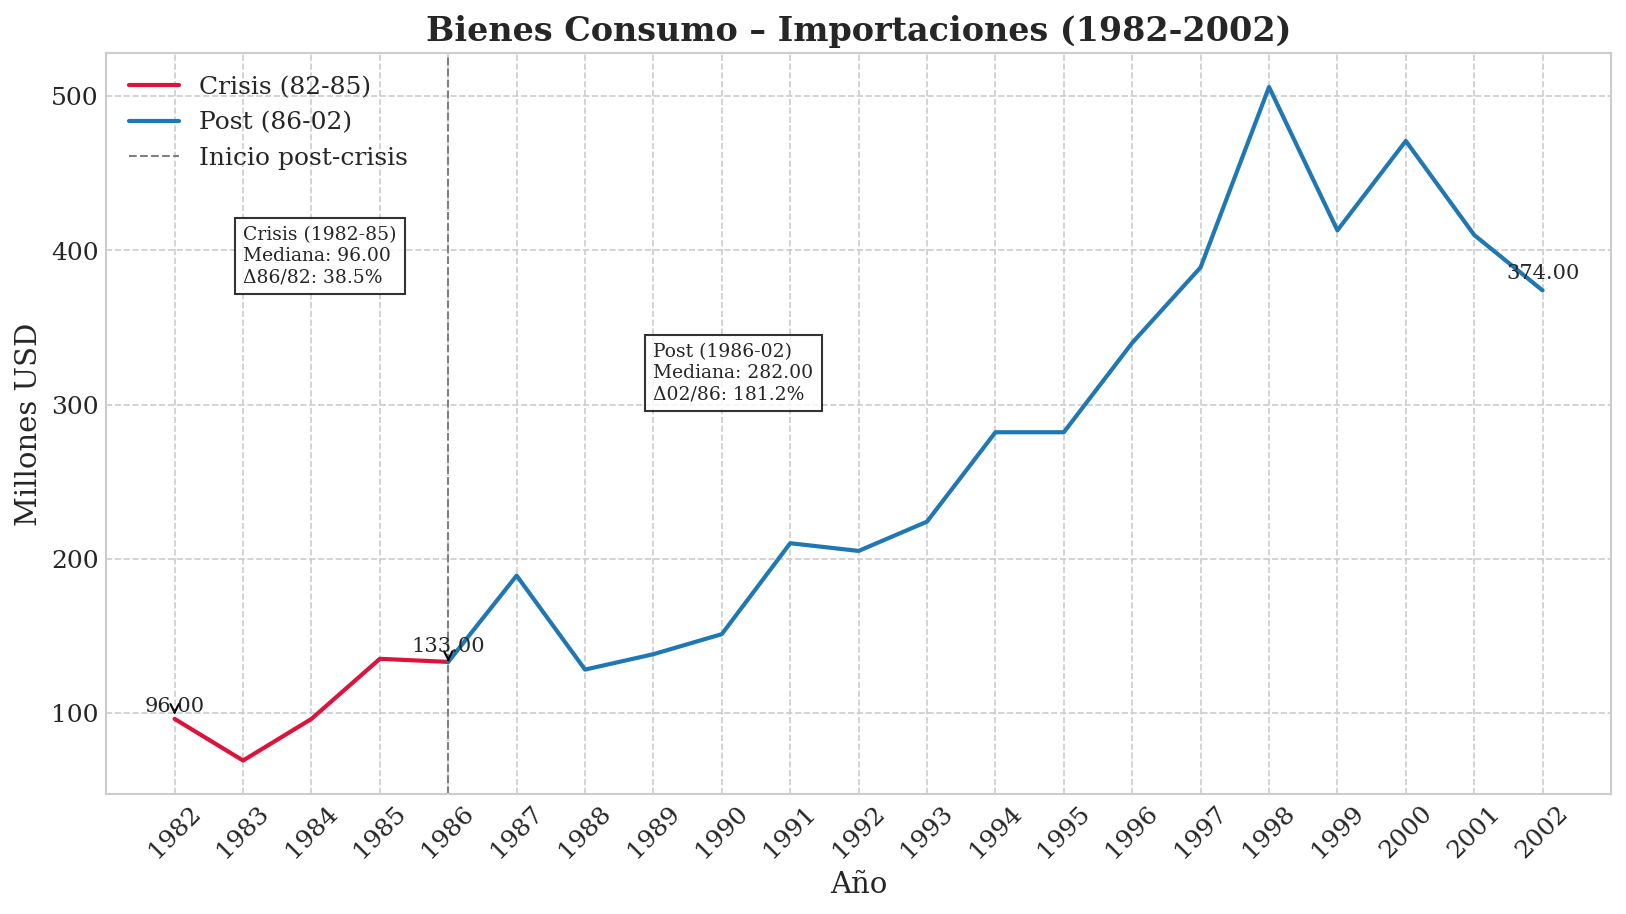

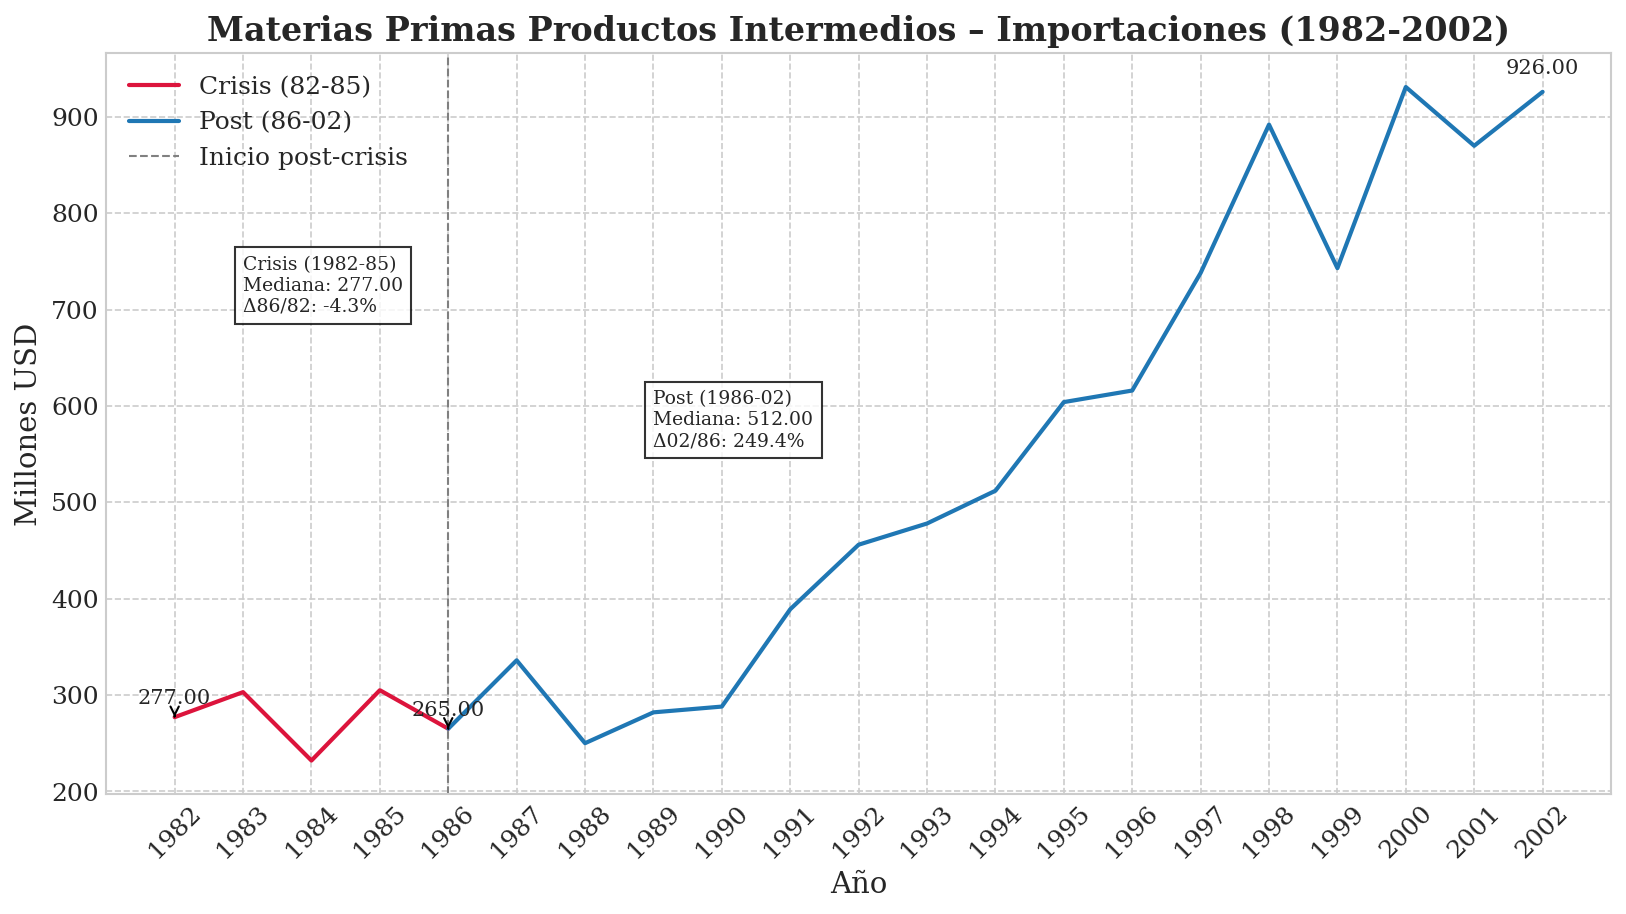

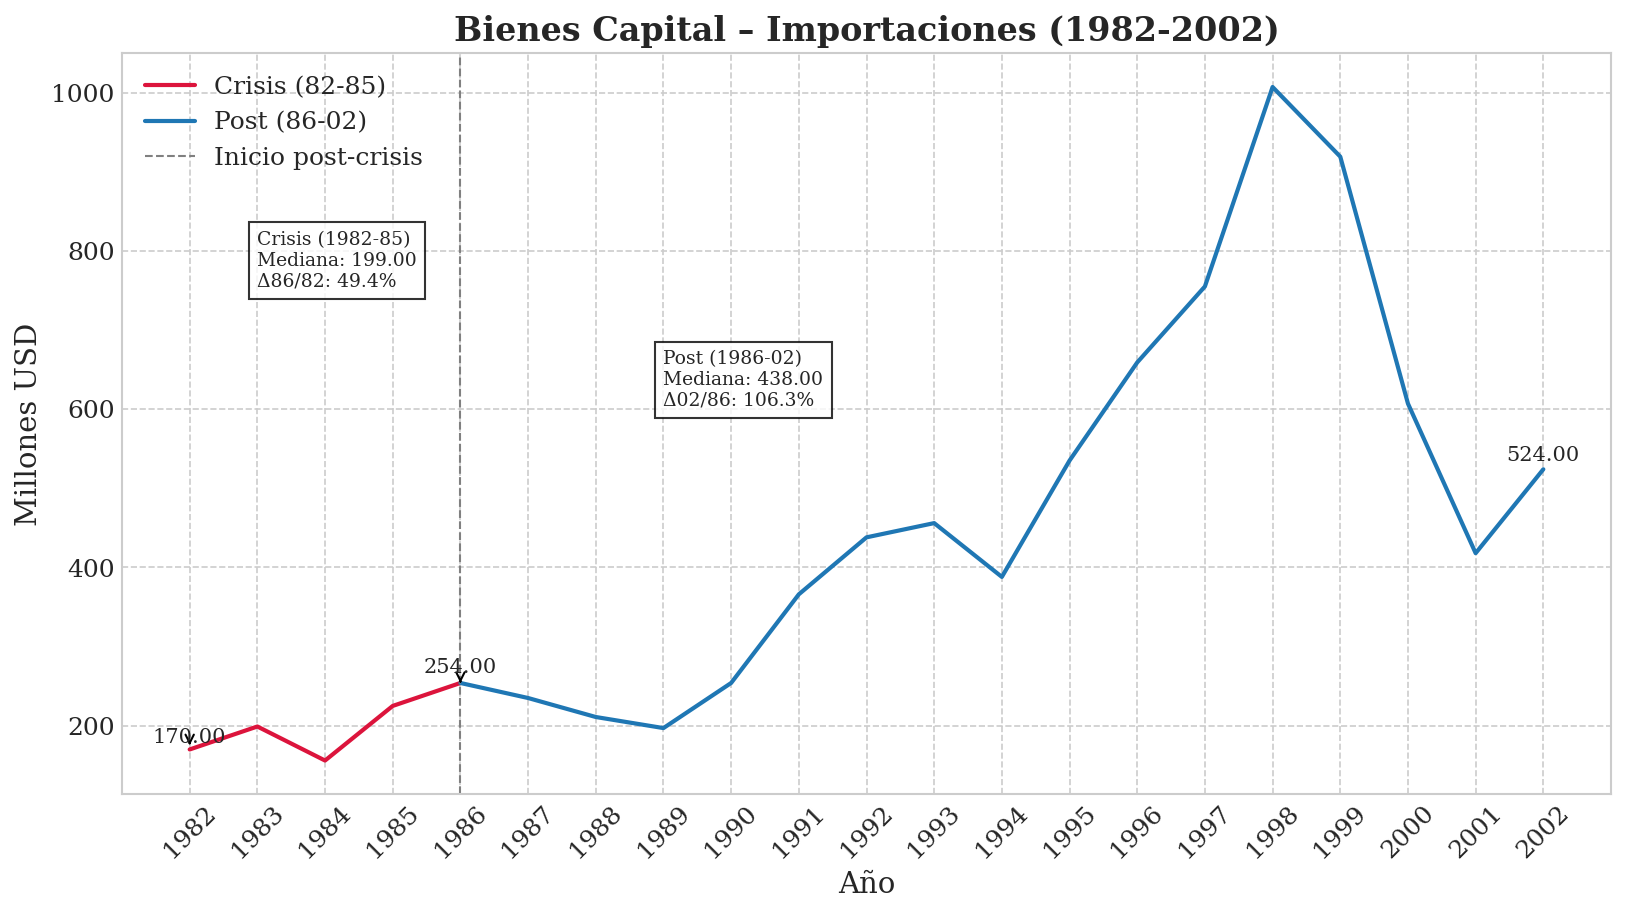

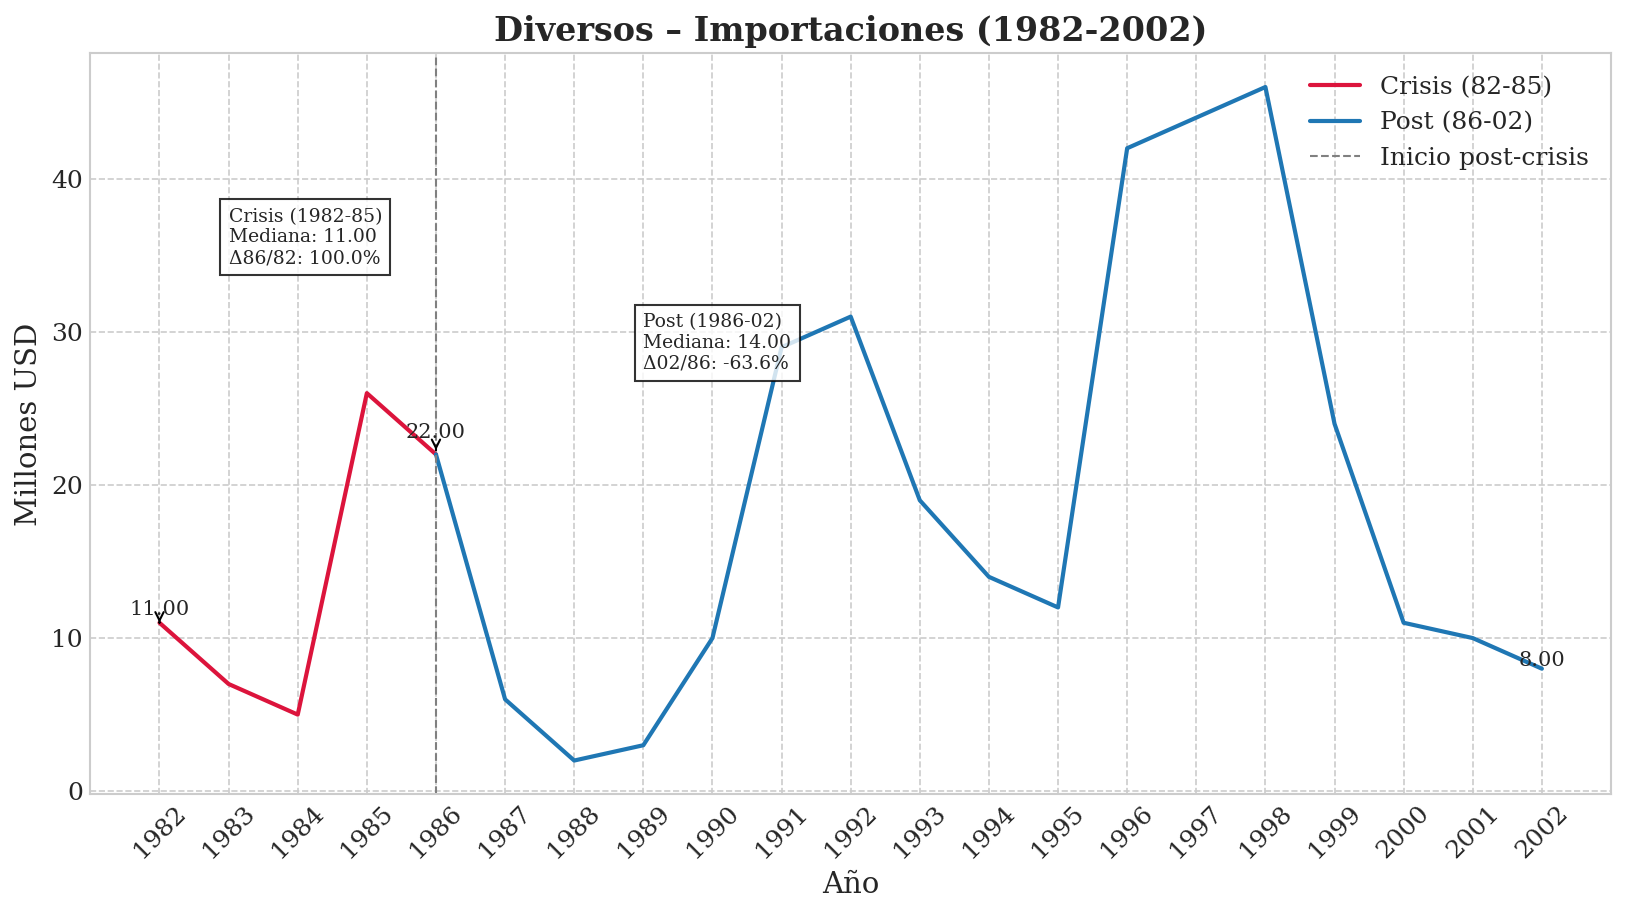

✓ Gráficas generadas en: ../../../assets/tesis/neoliberalismo/serie_completa/importaciones


In [7]:
"""
Genera automáticamente una gráfica por cada componente de la tabla
`composicion_importaciones_uso_destino` para el periodo 1982‑2002,
separando la fase de crisis (1982‑1985) y la post‑crisis (1986‑2002).

Cada PNG se guarda en:
../../../assets/tesis/intervensionismo_estatal/serie_completa/<componente>.png
"""

import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os

# ── Parámetros del estudio ────────────────────────────────────────────────────
CRISIS_YEARS   = slice(1982, 1986)   # 1982‑1985 inclusive
POST_YEARS     = slice(1986, 2002)   # 1986‑2002 inclusive
CLAVE_YEARS    = [1982, 1986, 2002]  # años a anotar
OUTPUT_DIR     = "../../../assets/tesis/neoliberalismo/serie_completa/importaciones"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ── Funciones auxiliares ──────────────────────────────────────────────────────
def cuadro_estadisticas_c(serie):
    med = serie.loc[CRISIS_YEARS].median()
    delta = (serie.loc[1986] - serie.loc[1982]) / serie.loc[1982] * 100
    return f"Crisis (1982‑85)\nMediana: {med:.2f}\nΔ86/82: {delta:.1f}%"

def cuadro_estadisticas_p(serie):
    med = serie.loc[POST_YEARS].median()
    delta = (serie.loc[2002] - serie.loc[1986]) / serie.loc[1986] * 100
    return f"Post (1986‑02)\nMediana: {med:.2f}\nΔ02/86: {delta:.1f}%"

# ── Cargar datos ──────────────────────────────────────────────────────────────
sql = "SELECT * FROM composicion_importaciones_uso_destino WHERE año BETWEEN 1982 AND 2002"
with sqlite3.connect("../../../db/proyectomacro.db") as conn:
    df = pd.read_sql(sql, conn, index_col="año")

# ── Columnas a graficar (excluye total si prefieres) ─────────────────────────
componentes = [c for c in df.columns if c != "total_valor_oficial_cif"]

# ── Estilo base ───────────────────────────────────────────────────────────────
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "font.family": "serif", "font.size": 12,
    "axes.titlesize": 16, "axes.labelsize": 14,
    "grid.linestyle": "--", "lines.linewidth": 2,
    "figure.dpi": 150, "savefig.bbox": "tight"
})

# ── Bucle de graficación ──────────────────────────────────────────────────────
for comp in componentes:
    serie = df[comp]

    # Segmentos
    serie_crisis = serie.loc[CRISIS_YEARS]
    serie_post   = serie.loc[POST_YEARS]

    # Figura
    fig, ax = plt.subplots(figsize=(11, 6))
    ax.plot(serie_crisis.index, serie_crisis, color="crimson", label="Crisis (82‑85)")
    ax.plot(serie_post.index,   serie_post,   color="#1f77b4", label="Post (86‑02)")
    ax.axvline(1986, color="gray", linestyle="--", linewidth=1, label="Inicio post‑crisis")

    # Anotaciones en años clave
    for yr in CLAVE_YEARS:
        val = serie.loc[yr]
        ytxt = val * 1.05 if yr != 2002 else val * 1.02
        ax.annotate(f"{val:.2f}", xy=(yr, val), xytext=(yr, ytxt),
                    ha="center", fontsize=10,
                    arrowprops=dict(arrowstyle="->") if yr != 2002 else None)

    # Cuadros estadísticos
    ymax = serie.max()
    ax.text(1983, ymax * 0.75, cuadro_estadisticas_c(serie),
            fontsize=9, bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"))
    ax.text(1989, ymax * 0.60, cuadro_estadisticas_p(serie),
            fontsize=9, bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"))

    # Etiquetas
    comp_titulo = comp.replace("_", " ").title()
    ax.set_title(f"{comp_titulo} – Importaciones (1982‑2002)", fontweight="bold")
    ax.set_xlabel("Año")
    ax.set_ylabel("Millones USD")
    ax.set_xticks(range(1982, 2003, 4))
    ax.legend()
    plt.tight_layout()
    plt.xticks(df.index,rotation=45)

    # Guardar
    fname = f"{comp}.png"
    plt.savefig(os.path.join(OUTPUT_DIR, fname))
    plt.show()
    plt.close(fig)

print(f"✓ Gráficas generadas en: {OUTPUT_DIR}")

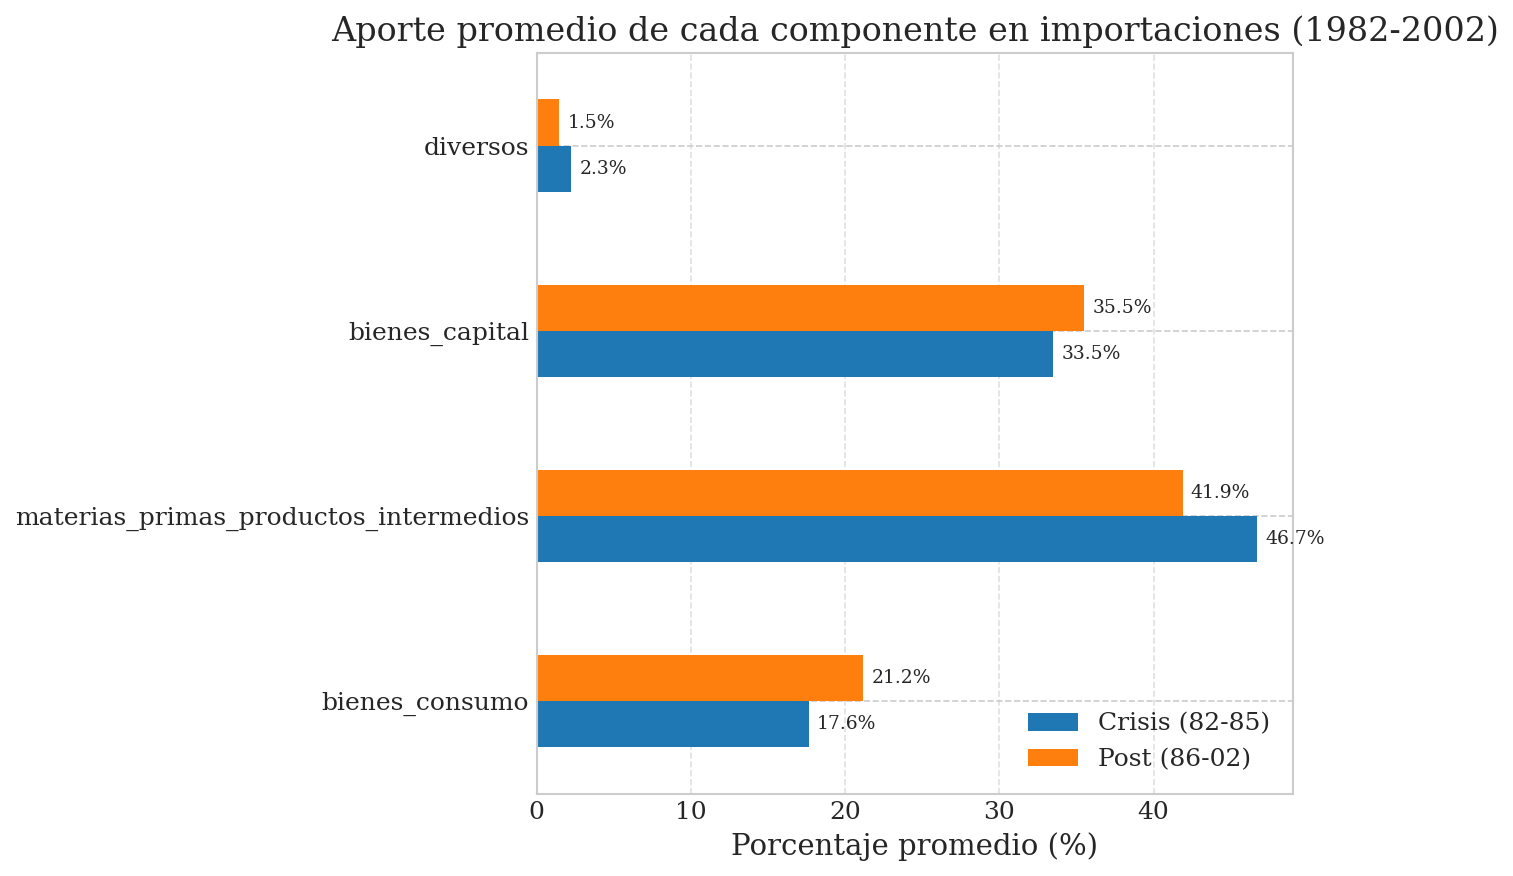

In [8]:
# ── Calcular porcentajes por año ───────────────────────────────────────────────
# total_valor_oficial_cif = importaciones totales (Millones USD)
pct = df.div(df["total_valor_oficial_cif"], axis=0) * 100

# ── Promedio en cada periodo ───────────────────────────────────────────────────
avg_crisis = pct.loc[CRISIS_YEARS].mean()
avg_post   = pct.loc[POST_YEARS].mean()
summary   = pd.DataFrame({
    "Crisis (82‑85)": avg_crisis,
    "Post (86‑02)":  avg_post
})
# ── Filtrar columnas (excluye 'total_valor_oficial_cif') ──────────────────────
summary_filtered = summary.drop("total_valor_oficial_cif", errors="ignore")

# ── Graficar ───────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 6))
bars = summary_filtered.plot.barh(ax=ax)

# ── Anotar valores numéricos al final de cada barra ───────────────────────────
for container in bars.containers:
    for bar in container:
        width = bar.get_width()
        ax.annotate(f"{width:.1f}%",
                    xy=(width, bar.get_y() + bar.get_height() / 2),
                    xytext=(4, 0),  # desplazamiento a la derecha
                    textcoords="offset points",
                    va='center', ha='left', fontsize=9)

# ── Etiquetas y estilo ────────────────────────────────────────────────────────
ax.set_xlabel("Porcentaje promedio (%)")
ax.set_title("Aporte promedio de cada componente en importaciones (1982‑2002)")
ax.legend(loc="lower right", framealpha=0.8)
ax.grid(axis="x", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "aporte_promedio_componentes.png"))
plt.show()

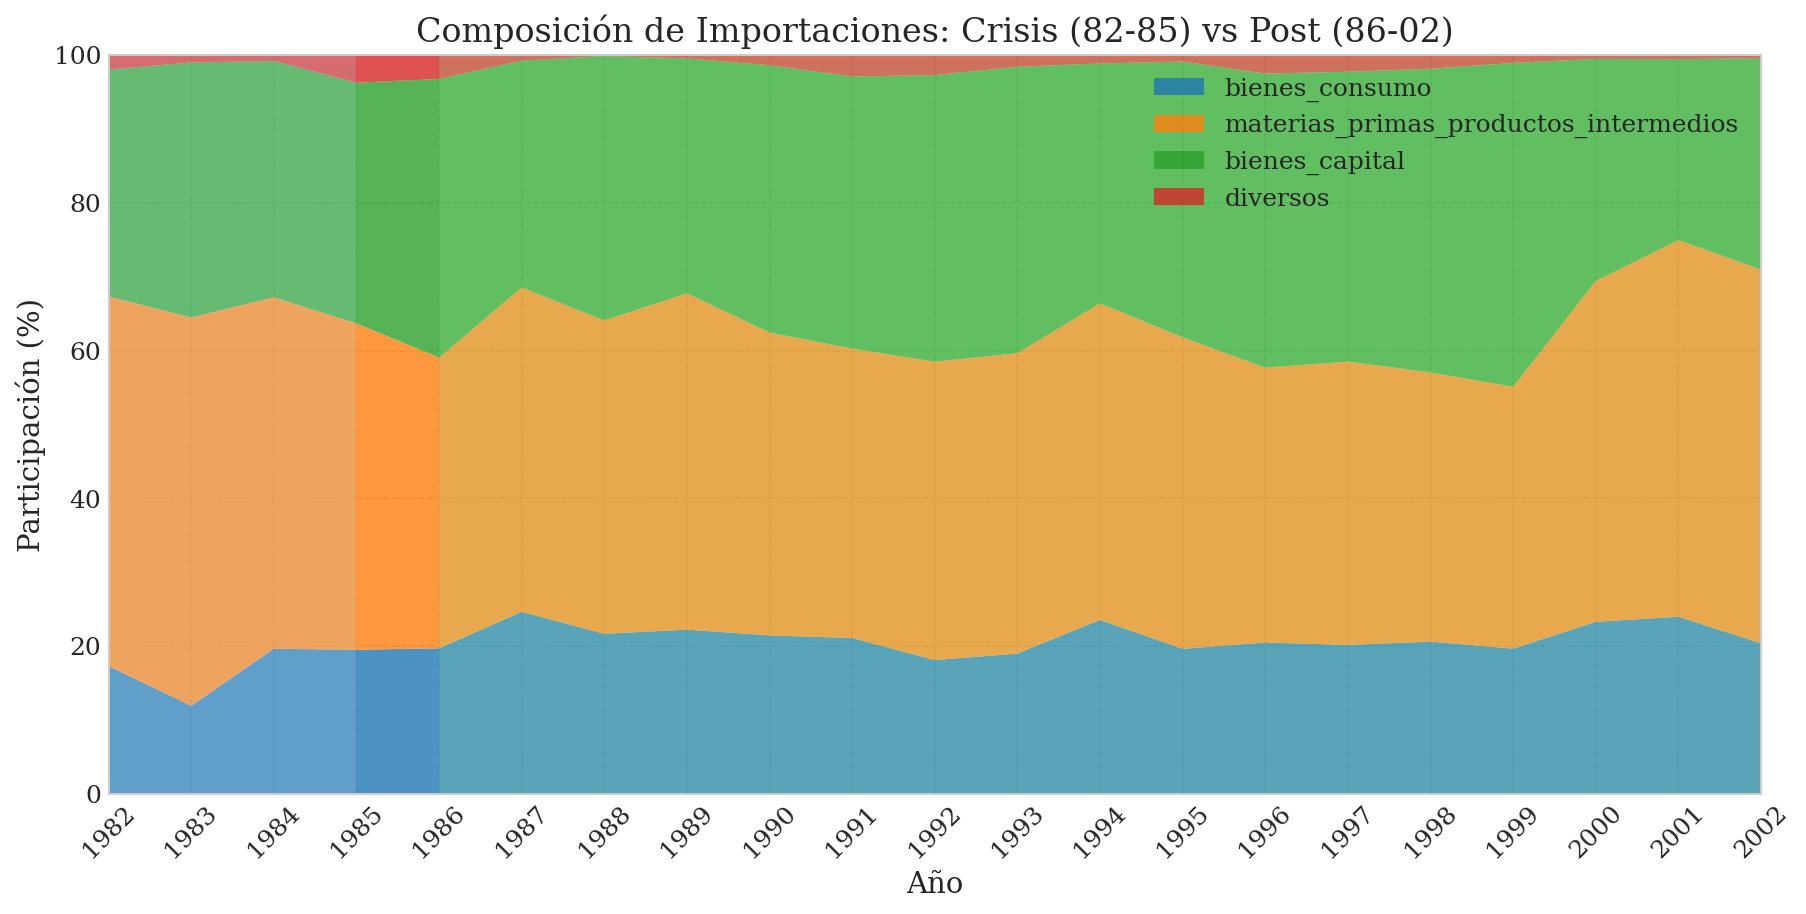

In [9]:
# ── Calcular participación (%) y descartar total ──────────────────────────────
pct = df.drop(columns=['total_valor_oficial_cif']) \
        .div(df['total_valor_oficial_cif'], axis=0) * 100
components = pct.columns

# ── Definir periodos ───────────────────────────────────────────────────────────
crisis = pct.loc[1982:1985]
post   = pct.loc[1986:2002]

# ── Funciones de estadística ──────────────────────────────────────────────────
def stats_text(label, s, start, end):
    med   = s.median()
    delta = (s.loc[end] - s.loc[start]) / s.loc[start] * 100
    return f"{label}: Mediana {med:.1f}%, Δ{end}/{start} {delta:.1f}%"

text_crisis = "Crisis (82‑85)\n" + "\n".join(
    stats_text(c, crisis[c], 1982, 1985) for c in components
)
text_post = "Post (86‑02)\n" + "\n".join(
    stats_text(c, post[c], 1986, 2002) for c in components
)

# ── Graficar stackplot ─────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))
ax.stackplot(pct.index,
             *(pct[c] for c in components),
             labels=components, alpha=0.8)

# ── Sombrear periodos ─────────────────────────────────────────────────────────
ax.axvspan(1982, 1985, facecolor='lightblue',  alpha=0.2)
ax.axvspan(1986, 2002, facecolor='lightgreen', alpha=0.2)



# ── Formato final ──────────────────────────────────────────────────────────────
ax.set_title('Composición de Importaciones: Crisis (82‑85) vs Post (86‑02)')
ax.set_xlabel('Año')
ax.set_ylabel('Participación (%)')
ax.set_xlim(1982, 2002)
ax.set_ylim(0, 100)
ax.legend(loc='upper right', ncol=1, framealpha=0.9)
plt.tight_layout()
plt.xticks(pct.index, rotation=45)

# ── Guardar ────────────────────────────────────────────────────────────────────

plt.savefig(os.path.join(OUTPUT_DIR , "comp_importaciones_82_02.png"), dpi=300)
plt.show()
plt.close(fig)

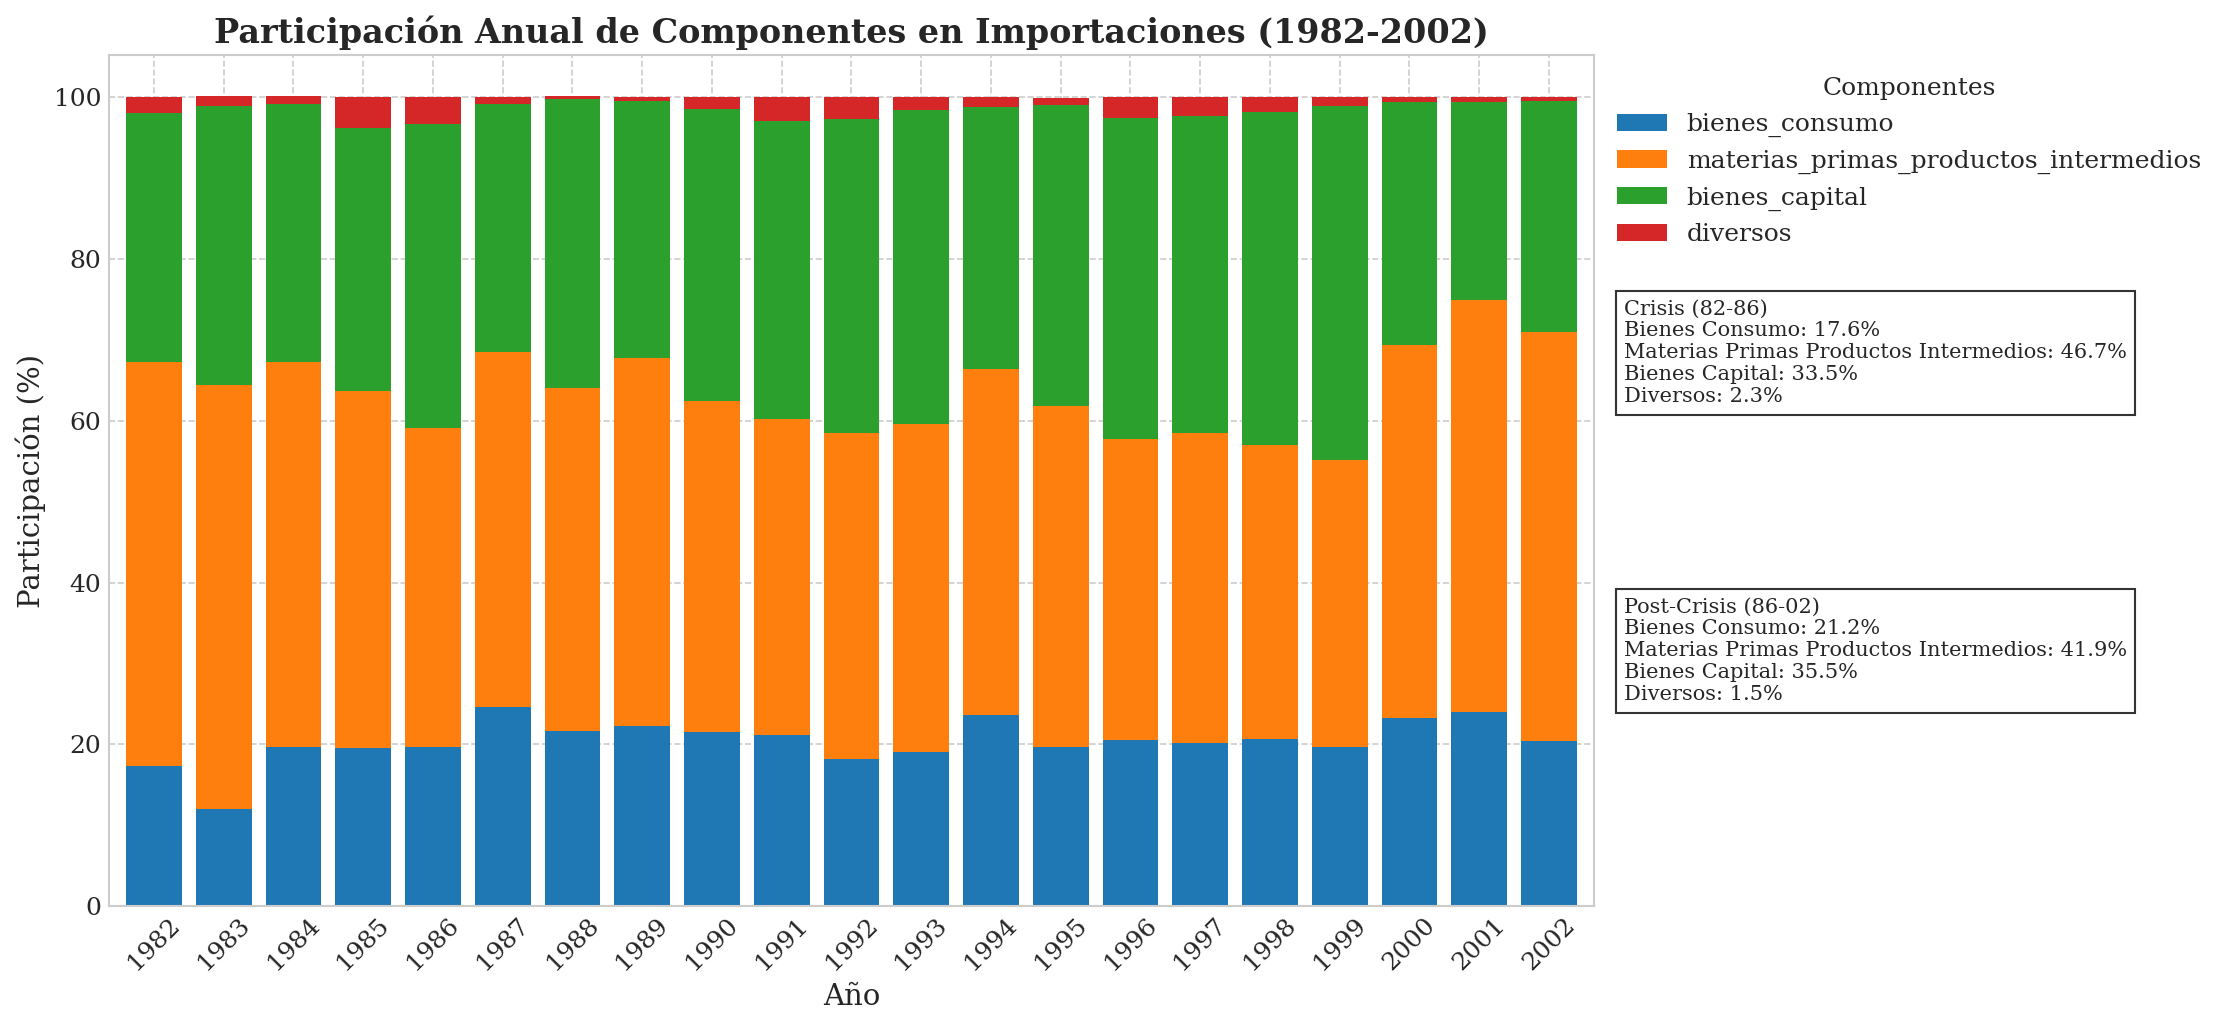

In [10]:

# ── 2. Preparar participaciones (%) ───────────────────────────────────────────
componentes = [c for c in df.columns if c != "total_valor_oficial_cif"]
pct = df[componentes].div(df["total_valor_oficial_cif"], axis=0) * 100

# ── 3. Estadísticas promedio por periodo ────────────────────────────────────
avg_crisis = pct.loc[1982:1986].mean()
avg_post   = pct.loc[1986:2002].mean()

# ── 4. Gráfico stacked‑bar por año ────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(15, 7))
pct.plot(kind="bar", stacked=True, ax=ax, width=0.8)

ax.set_ylabel("Participación (%)")
ax.set_xlabel("Año")
ax.set_title("Participación Anual de Componentes en Importaciones (1982‑2002)", fontweight="bold")
ax.legend(loc="upper left", bbox_to_anchor=(1,1), title="Componentes")
plt.xticks(rotation=45)

# ── 5. Cuadros con promedios de crisis y post‑crisis ─────────────────────────
stats_crisis = "\n".join(f"{comp.replace('_',' ').title()}: {avg_crisis[comp]:.1f}%"
                         for comp in componentes)
stats_post   = "\n".join(f"{comp.replace('_',' ').title()}: {avg_post[comp]:.1f}%"
                         for comp in componentes)

# Crisis box (82‑86)
ax.text(1.02, 0.65, "Crisis (82‑86)\n" + stats_crisis,
        transform=ax.transAxes, fontsize=10, va="center", ha="left",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"))

# Post‑crisis box (86‑02)
ax.text(1.02, 0.30, "Post‑Crisis (86‑02)\n" + stats_post,
        transform=ax.transAxes, fontsize=10, va="center", ha="left",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="black"))

# ── 6. Guardar y mostrar ─────────────────────────────────────────────────────
out_dir = "../../../assets/tesis/neoliberalismo/serie_completa"
os.makedirs(out_dir, exist_ok=True)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "participaciones_anuales_componentes.png"), dpi=300)
plt.show()